In [1]:
import cobra
import pandas as pd 
import os
from os.path import join 
from cobra import Model, Reaction, Metabolite
from cobra.sampling import sampling 
import numpy as np
os.environ["R_HOME"] = f"{os.environ['CONDA_PREFIX']}\\Lib\\R"
import rpy2.robjects
from plotnine import *
import matplotlib.pyplot as plt 

In [2]:
# Importing the model
model1=cobra.io.read_sbml_model("C:\\Users\\Maive\\Desktop\\BSc_loputoo\\Model_files\\iRhto_models\\iRhtoC.xml")
model1.objective = "ATPM_c" 

solution1 = model1.optimize('minimize')
# All fluxes
all_fluxes = solution1.fluxes.to_frame(name='Flux')
all_fluxes

Set parameter Username
Academic license - for non-commercial use only - expires 2025-01-21


,Flux
RLFC2O_c,0.0
RLFC2O_m,0.0
BTDDH_c,0.0
LLFC2O_c,0.0
13GS_c,0.0
...,...
ECOAI82e_x,0.0
DECOAI82e_x,0.0
DECOAR82e_x,0.0
ECOAI81e_x,0.0


In [2]:
# Lab data
glucose_uptakes = [0.476, 1.114, 1.648, 2.305, 3.1]  # in lab they didn't calculate glc uptake when gR was 0.25 so it's not included
growth_rates = [0.033972, 0.082746, 0.12357, 0.173796, 0.234573] # calculated these GR when optimized for biomass max and constrained glc uptakes, bc model is infeasible when trying to connstrain both glc uptake and GR from lab data - original: [0.033972, 0.082746, 0.12357, 0.173796, 0.234573]


In [4]:
# Get all fluxes on different glucose uptake
all_fluxes_NGAM_min = pd.DataFrame(columns=['Glucose uptake', 'Growth rate', *all_fluxes.index], index=range(len(glucose_uptakes))) #flux_values.index gives the row names column, * extracts the list of strings

for i in range(len(glucose_uptakes)):
    model=cobra.io.read_sbml_model("C:\\Users\\Maive\\Desktop\\BSc_loputoo\\Model_files\\iRhto_models\\iRhtoC.xml")
    model.objective = "ATPM_c"  
    model.reactions.EX_glc__D_e.bounds = -(glucose_uptakes[i]), -(glucose_uptakes[i])
    model.reactions.BIOMASS_RT_CLIM.bounds = growth_rates[i], growth_rates[i]
    
    solution = model.optimize('minimize') #
    
    all_fluxes_NGAM_min.loc[i] = solution.fluxes[['EX_glc__D_e', 'BIOMASS_RT_CLIM', *all_fluxes.index]].values
    
all_fluxes_NGAM_min


,Glucose uptake,Growth rate,RLFC2O_c,RLFC2O_m,BTDDH_c,LLFC2O_c,13GS_c,16GS_c,PRMICI_c,P5CD_m,...,ECOAH101e_x,HACD101ei_x,ACACT101ei_x,ACOAD82ef_x,ACOAO82e_x,ECOAI82e_x,DECOAI82e_x,DECOAR82e_x,ECOAI81e_x,PACCOAE_x
0,-0.476,0.033972,0.0,0.0,0.0,0.0,0.03401,0.00895,0.002592,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-1.114,0.082746,0.0,0.0,0.0,0.0,0.082839,0.0218,0.006314,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-1.648,0.12357,0.0,0.0,0.0,0.0,0.123709,0.032555,0.009429,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-2.305,0.173796,0.0,0.0,0.0,0.0,0.173991,0.045787,0.013261,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-3.1,0.234573,0.0,0.0,0.0,0.0,0.234836,0.061799,0.017898,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
# Get specific metabolites with their fluxes
exchange_fluxes_table = all_fluxes_NGAM_min[['EX_glc__D_e', 'EX_o2_e', 'EX_nh4_e','EX_so4_e','EX_pi_e', 'EX_co2_e']]

for i in range(len(exchange_fluxes_table.columns)):
    exchange_fluxes_table = exchange_fluxes_table.rename(columns = {exchange_fluxes_table.columns[i]: getattr(model.reactions, exchange_fluxes_table.columns[i]).name})

exchange_fluxes_table

,D-glucose exchange,oxygen exchange,ammonium exchange,sulphate exchange,phosphate exchange,carbon dioxide exchange
0,-0.476,-1.299967,-0.219389,-0.00279,-0.018291,1.436345
1,-1.114,-2.893951,-0.534369,-0.006796,-0.044552,3.22613
2,-1.648,-4.228093,-0.798008,-0.010149,-0.066533,4.724152
3,-2.305,-5.86955,-1.122365,-0.014274,-0.093576,6.567245
4,-3.1,-7.855756,-1.51486,-0.019265,-0.126299,8.797437


In [6]:
intracellular_fluxes = all_fluxes_NGAM_min[['ATPM_c', 'EX_glc__D_e', 'G6PDH2i_c', 'TKT1_c', 'TALA_c','TKT2_c', 'PKETF_c', 'FBA_c',  'PYRDC_c','PDH_m', 'ACITL_c']] #doesn't have 'XPK' (Xylulose-5-phosphate phosphoketolase), it has only 'FPK' (Fructose-6-phosphate phosphoketolase)
# Change column IDs to names
for i in range(len(intracellular_fluxes.columns)):
    intracellular_fluxes = intracellular_fluxes.rename(columns = {intracellular_fluxes.columns[i]: getattr(model.reactions, intracellular_fluxes.columns[i]).name})

intracellular_fluxes = intracellular_fluxes.rename(columns = {'glucose 6-phosphate dehydrogenase': 'oxPPP', 'ATP maintenance requirement': 'NGAM'})
intracellular_fluxes

,NGAM,D-glucose exchange,oxPPP,transketolase 1,transaldolase,transketolase 2,phosphoketolase (fructose 6-phosphate),fructose-bisphosphate aldolase,pyruvate decarboxylase,pyruvate dehydrogenase,ATP citrate lyase
0,1.189,-0.476,0.245009,0.080558,-0.242932,0.071992,0.0,0.0,0.0,0.531101,0.187383
1,1.189,-1.114,0.596772,0.196221,0.196221,0.175358,0.0,0.742539,0.0,1.202824,0.456412
2,1.189,-1.648,0.891078,0.292989,0.292989,0.261832,0.0,1.093314,0.0,1.765078,0.681584
3,1.189,-2.305,1.253209,0.412059,-1.112817,0.368238,0.0,0.0,0.0,2.45684,0.958628
4,1.189,-3.1,1.69146,0.556157,-1.490907,0.497012,0.0,0.0,0.0,3.293874,1.293863


Text(0, 0.5, 'Flux $(g/gDW/h)$')

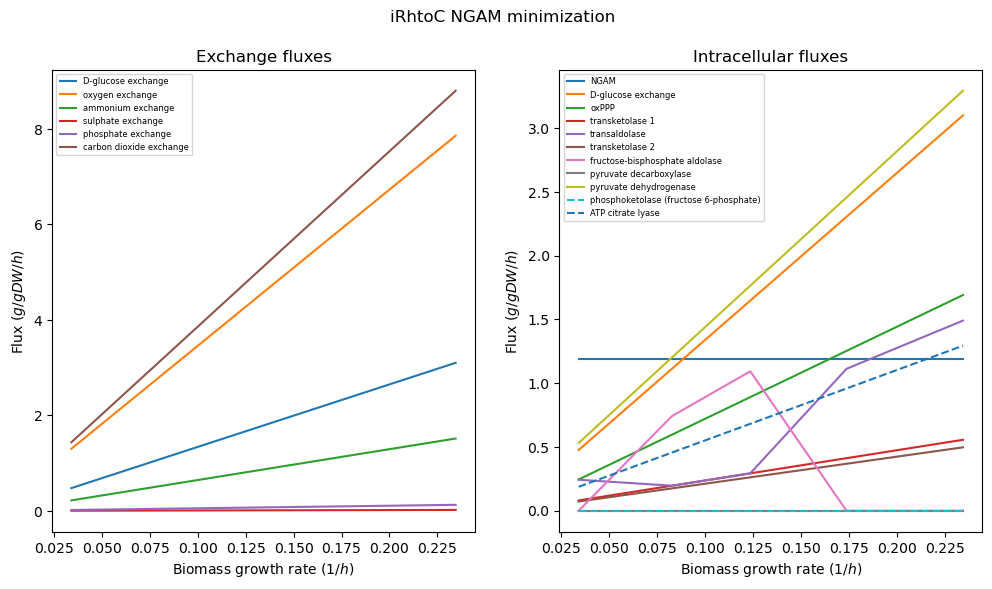

In [7]:
# Plot exchange and intracellular fluxes
fig, ax = plt.subplots(1, 2, figsize=(12,6)) #, 
fig.suptitle('iRhtoC NGAM minimization')

# Sample data

x1 = all_fluxes_NGAM_min['BIOMASS_RT_CLIM']
y1 = np.abs(exchange_fluxes_table)

ax[0].plot(x1, y1, '-', label= y1.columns) #
ax[0].legend(fontsize=6, loc='upper left')
ax[0].set_title("Exchange fluxes") #fluxes biomass maximization
ax[0].set_xlabel('Biomass growth rate $(1/h)$')
ax[0].set_ylabel('Flux $(g/gDW/h)$')
 
x2 = all_fluxes_NGAM_min['BIOMASS_RT_CLIM']
y2 = np.abs(intracellular_fluxes.drop(columns = ['phosphoketolase (fructose 6-phosphate)','ATP citrate lyase']))
y3 = np.abs(intracellular_fluxes[['phosphoketolase (fructose 6-phosphate)','ATP citrate lyase']])

ax[1].plot(x2, y2, '-', label= y2.columns) #
ax[1].plot(x2, y3, '--', label= y3.columns) # ACL and phosphoketolase

ax[1].legend(fontsize=6, loc='upper left')
ax[1].set_title("Intracellular fluxes")
ax[1].set_xlabel('Biomass growth rate $(1/h)$')
ax[1].set_ylabel('Flux $(g/gDW/h)$')

In [8]:
# # Get all fluxes to excel
# with pd.ExcelWriter('C:\\Users\\Maive\\Desktop\\BSc_loputoo\\Results\\iRhto_results\\iRhto_all_fluxes_glc_max.xlsx') as excel_writer:
#     all_fluxes_glc_max.to_excel(excel_writer, sheet_name='Growth rates 0.05-0.3', index=True)

COFACTOR BALANCES - look file iRhto cofactor balances